In [1]:
import numpy as np
import pandas as pd
import scipy.io

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

# Classification with time series

_Objectives_ :
  * using 1D CNN
  * using LSTLM

In [2]:
def show_history(history):
    plt.figure()    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Activity classification

HAR Dataset by WISDM

# Data preparation

  * Importation
  * Normalization (by mean and std)
  * Visualization
  * Time segmentation
  * Encoding

In [3]:
# Importation
columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis']
df = pd.read_csv("actitracker_raw.csv", header = None, names=columnNames,na_values=';')
df.describe()
print(df.shape)

(1098204, 6)


In [4]:
# Normalization
sub_df = df[['x-axis','y-axis','z-axis']]
sub_df = (sub_df-sub_df.mean())/sub_df.std()
df[['x-axis','y-axis','z-axis']] = sub_df
df.describe()

,user_id,timestamp,x-axis,y-axis,z-axis
count,1.098204e+06,1.098204e+06,1.098204e+06,1.098204e+06,1.098203e+06
mean,1.886066e+01,3.340907e+13,5.236491e-15,6.931031e-13,1.857748e-14
std,1.021423e+01,4.944967e+13,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000e+00,0.000000e+00,-2.959950e+00,-3.982334e+00,-4.251282e+00
25%,1.000000e+01,2.019113e+12,-5.158181e-01,-6.056204e-01,-5.534289e-01
50%,1.900000e+01,9.722777e+12,-5.736087e-02,9.996151e-02,-8.646449e-02
75%,2.800000e+01,4.996570e+13,5.514820e-01,6.380419e-01,4.856721e-01
max,3.600000e+01,2.093974e+14,2.816027e+00,1.895045e+00,4.038388e+00


In [5]:
def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)# defining a function to plot the data for a given activity
    
def plotActivity(activity,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
    plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
    plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

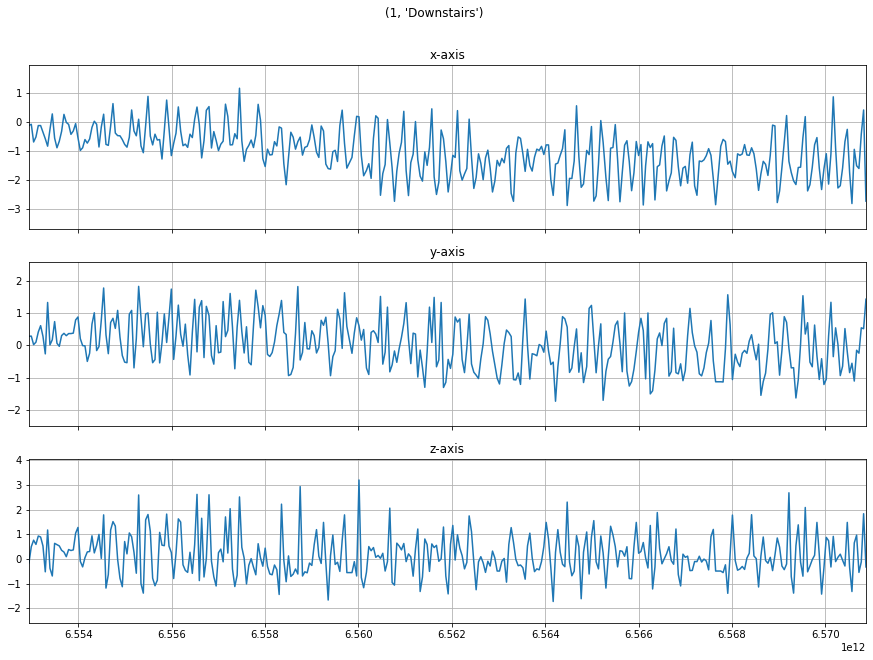

In [6]:
users = [*df.groupby(["user_id", "activity"])]
# Select first user, his first activity with only 360 first elements
plotActivity(users[0][0], users[0][1][:360])

#### Segmentation

For each time window, we take the activity of the first sample. Sometime, the activity change after the first sample, distorting labeling. But this case is quite rare. 

In [7]:
xyz = np.array(df[['x-axis','y-axis','z-axis']])

activities = df[['activity']]
sequences = []
labels = []

windows_size = 90
step = 45

for i in range(0, len(xyz)-windows_size, step):
    sequences.append(xyz[i:i+windows_size])
    labels.append(activities.loc[i].values[0])
    
sequences = np.array(sequences)
sequences = np.nan_to_num(sequences)
print(sequences.shape)

(24403, 90, 3)


In [8]:
# Encoding
one_encorder = OneHotEncoder(sparse=False)
label_enc = LabelEncoder()
labels_enc = label_enc.fit_transform(labels) # String to num
labels_enc = one_encorder.fit_transform(labels_enc.reshape(-1, 1)) # Num to one-hot vector

X_train, X_test, y_train, y_test = train_test_split(sequences, labels_enc, test_size=0.2)

# 1D CNN

We can also use 2D CNN by transforming chanels to a second axe. The original shape is (batch_size, window_size, chanels), here (64, 90, 3) to (batch_size, window_size, ""chanels"", chanels), here (64, 90, 3, 1). The result is the same.

In [9]:
def build_model_conv1D():
    model = models.Sequential()# (1)
    
    model.add(layers.Conv1D(100, 3, activation='relu', input_shape=(windows_size, 3)))
    model.add(layers.Conv1D(100, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Conv1D(160, 3, activation='relu'))
    model.add(layers.Conv1D(160, 3, activation='relu'))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(6, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['acc'])
    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 100)           1000      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 86, 100)           30100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 43, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 160)           48160     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 39, 160)           76960     
_________________________________________________________________
global_average_pooling1d (Gl (None, 160)               0         
_________________________________________________________________
dropout (Dropout)            (None, 160)               0

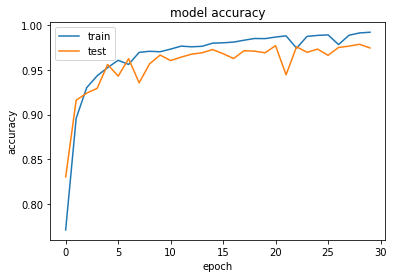

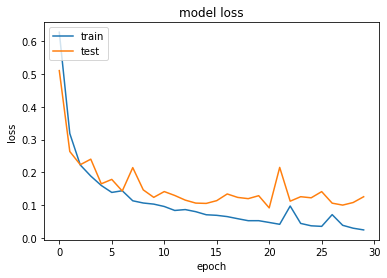

In [10]:
model = build_model_conv1D()
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2)
model.evaluate(X_test, y_test)
show_history(history)

In [11]:
# Lighter CNN
def build_model_conv1D_v2():
    model = models.Sequential()# (1)
    
    model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(windows_size, 3)))
    model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['acc'])
    model.summary()
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 88, 32)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 44, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               180352    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 181,446
Trainable params: 181,446
Non-trainable params: 0
________________________________________________

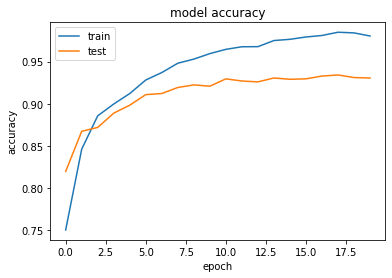

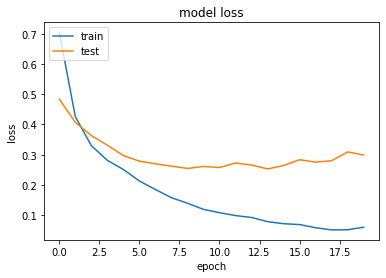

In [12]:
model = build_model_conv1D_v2()
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)
model.evaluate(X_test, y_test)
show_history(history)

# LSTM

In [13]:
def build_model():
    model = models.Sequential()# (1)
    
    model.add(layers.LSTM(128, return_sequences=True, input_shape=(90, 3)))
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())
    
    model.add(layers.LSTM(128))
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(6, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['acc'])
    model.summary()
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 128)           67584     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

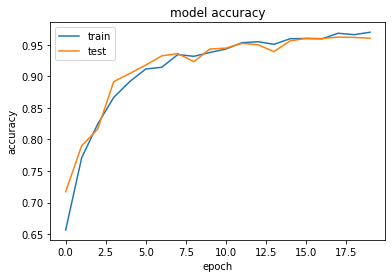

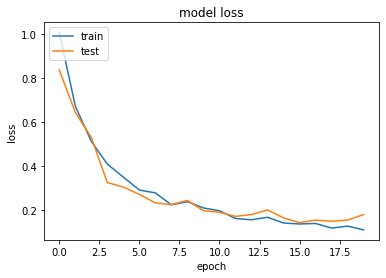

In [14]:
model = build_model()
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)
model.evaluate(X_test, y_test)
show_history(history)

In [15]:
# Lighter LSTM
def build_model_LSTM():
    model = models.Sequential()# (1)
    
    model.add(layers.LSTM(128, input_shape=(90, 3)))
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['acc'])
    model.summary()
    return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 198       
Total params: 72,422
Trainable params: 72,166
Non-trainable params: 256
_________________________________________________________________
Train on 15617 samples, validate on 3905 samples
Epoch 1/15
15617/15617 [==============================] - 19s 1ms

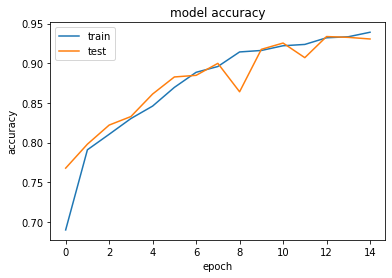

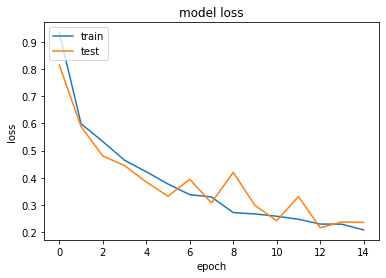

In [16]:
model = build_model_LSTM()
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2)
model.evaluate(X_test, y_test)
show_history(history)

# Movement classification

### Data preparation
  * Importation
  * Padding
  * Encoding
  
The data is already split in squences.

In [17]:
skltons = scipy.io.loadmat('data/sequences.mat')["sequences"][0]
labels = scipy.io.loadmat('data/action_labels.mat')["labels"][0]

In [18]:
one_encoder = OneHotEncoder(sparse=False)
labels_enc = one_encoder.fit_transform(labels.reshape(-1, 1))
n_cat = len(one_encoder.categories_[0])


# Find the max num of samples in sequences for padding the others
max_len = 0
for seq in skltons:
    if max_len < seq.shape[0]:
        max_len = seq.shape[0]
print(max_len)
        
sequences = []
for seq in skltons:
    seq = seq.reshape(-1, 3*15)
    result = np.zeros((max_len, 45))
    result[:seq.shape[0],:seq.shape[1]] = seq
    sequences.append(result)
    
sequences = np.array(sequences)
print(sequences.shape)
X_train, X_test, y_train, y_test = train_test_split(sequences, labels_enc, test_size=0.2)

35
(215, 35, 45)


# LSTM

In [19]:
def build_model_light_LSTM():
    model = models.Sequential()# (1)
    
    model.add(layers.LSTM(128, input_shape=(max_len, 45)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(n_cat, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=0.00002), metrics=['acc'])
    model.summary()
    return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               89088     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 297       
Total params: 94,025
Trainable params: 93,769
Non-trainable params: 256
_________________________________________________________________
Train on 172 samples, validate on 43 samples
Epoch 1/1000
172/172 [==============================] - 2s 11ms/sampl

Epoch 53/1000
172/172 [==============================] - 0s 382us/sample - loss: 2.1782 - acc: 0.2035 - val_loss: 2.1821 - val_acc: 0.2791
Epoch 54/1000
172/172 [==============================] - 0s 360us/sample - loss: 2.1256 - acc: 0.2209 - val_loss: 2.1819 - val_acc: 0.2791
Epoch 55/1000
172/172 [==============================] - 0s 344us/sample - loss: 2.1151 - acc: 0.2384 - val_loss: 2.1817 - val_acc: 0.2791
Epoch 56/1000
172/172 [==============================] - 0s 361us/sample - loss: 2.1441 - acc: 0.2326 - val_loss: 2.1815 - val_acc: 0.2791
Epoch 57/1000
172/172 [==============================] - 0s 354us/sample - loss: 2.1149 - acc: 0.2384 - val_loss: 2.1813 - val_acc: 0.2791
Epoch 58/1000
172/172 [==============================] - 0s 377us/sample - loss: 2.1410 - acc: 0.2151 - val_loss: 2.1810 - val_acc: 0.2791
Epoch 59/1000
172/172 [==============================] - 0s 348us/sample - loss: 2.1292 - acc: 0.2384 - val_loss: 2.1807 - val_acc: 0.3023
Epoch 60/1000
172/172 [====

Epoch 112/1000
172/172 [==============================] - 0s 355us/sample - loss: 2.0007 - acc: 0.2733 - val_loss: 2.1659 - val_acc: 0.3256
Epoch 113/1000
172/172 [==============================] - 0s 350us/sample - loss: 1.9850 - acc: 0.2907 - val_loss: 2.1654 - val_acc: 0.3256
Epoch 114/1000
172/172 [==============================] - 0s 355us/sample - loss: 2.0158 - acc: 0.2733 - val_loss: 2.1649 - val_acc: 0.3256
Epoch 115/1000
172/172 [==============================] - 0s 356us/sample - loss: 2.0125 - acc: 0.2674 - val_loss: 2.1647 - val_acc: 0.3256
Epoch 116/1000
172/172 [==============================] - 0s 351us/sample - loss: 1.9975 - acc: 0.2849 - val_loss: 2.1644 - val_acc: 0.3256
Epoch 117/1000
172/172 [==============================] - 0s 385us/sample - loss: 2.0112 - acc: 0.3023 - val_loss: 2.1640 - val_acc: 0.3256
Epoch 118/1000
172/172 [==============================] - 0s 383us/sample - loss: 1.9934 - acc: 0.2907 - val_loss: 2.1639 - val_acc: 0.3256
Epoch 119/1000
172/1

Epoch 171/1000
172/172 [==============================] - 0s 374us/sample - loss: 1.9132 - acc: 0.2965 - val_loss: 2.1424 - val_acc: 0.3256
Epoch 172/1000
172/172 [==============================] - 0s 352us/sample - loss: 1.8948 - acc: 0.2907 - val_loss: 2.1420 - val_acc: 0.3256
Epoch 173/1000
172/172 [==============================] - 0s 343us/sample - loss: 1.8949 - acc: 0.3023 - val_loss: 2.1421 - val_acc: 0.3256
Epoch 174/1000
172/172 [==============================] - 0s 361us/sample - loss: 1.8996 - acc: 0.2907 - val_loss: 2.1415 - val_acc: 0.3256
Epoch 175/1000
172/172 [==============================] - 0s 384us/sample - loss: 1.8950 - acc: 0.3314 - val_loss: 2.1411 - val_acc: 0.3256
Epoch 176/1000
172/172 [==============================] - 0s 402us/sample - loss: 1.8960 - acc: 0.3023 - val_loss: 2.1410 - val_acc: 0.3256
Epoch 177/1000
172/172 [==============================] - 0s 426us/sample - loss: 1.9007 - acc: 0.2965 - val_loss: 2.1406 - val_acc: 0.3256
Epoch 178/1000
172/1

Epoch 230/1000
172/172 [==============================] - 0s 390us/sample - loss: 1.8103 - acc: 0.3372 - val_loss: 2.1022 - val_acc: 0.3721
Epoch 231/1000
172/172 [==============================] - 0s 373us/sample - loss: 1.7855 - acc: 0.3430 - val_loss: 2.1019 - val_acc: 0.3721
Epoch 232/1000
172/172 [==============================] - 0s 381us/sample - loss: 1.8336 - acc: 0.3372 - val_loss: 2.1015 - val_acc: 0.3721
Epoch 233/1000
172/172 [==============================] - 0s 387us/sample - loss: 1.8029 - acc: 0.3256 - val_loss: 2.1009 - val_acc: 0.3488
Epoch 234/1000
172/172 [==============================] - 0s 374us/sample - loss: 1.8122 - acc: 0.3314 - val_loss: 2.0988 - val_acc: 0.3488
Epoch 235/1000
172/172 [==============================] - 0s 373us/sample - loss: 1.8102 - acc: 0.3547 - val_loss: 2.0977 - val_acc: 0.3488
Epoch 236/1000
172/172 [==============================] - 0s 382us/sample - loss: 1.8554 - acc: 0.3488 - val_loss: 2.0958 - val_acc: 0.3488
Epoch 237/1000
172/1

Epoch 289/1000
172/172 [==============================] - 0s 372us/sample - loss: 1.7265 - acc: 0.3721 - val_loss: 2.0358 - val_acc: 0.3721
Epoch 290/1000
172/172 [==============================] - 0s 376us/sample - loss: 1.7361 - acc: 0.3547 - val_loss: 2.0343 - val_acc: 0.3721
Epoch 291/1000
172/172 [==============================] - 0s 393us/sample - loss: 1.6785 - acc: 0.3895 - val_loss: 2.0324 - val_acc: 0.3721
Epoch 292/1000
172/172 [==============================] - 0s 370us/sample - loss: 1.7128 - acc: 0.3605 - val_loss: 2.0330 - val_acc: 0.3721
Epoch 293/1000
172/172 [==============================] - 0s 372us/sample - loss: 1.7124 - acc: 0.3779 - val_loss: 2.0303 - val_acc: 0.3721
Epoch 294/1000
172/172 [==============================] - 0s 365us/sample - loss: 1.7072 - acc: 0.3779 - val_loss: 2.0279 - val_acc: 0.3721
Epoch 295/1000
172/172 [==============================] - 0s 392us/sample - loss: 1.6745 - acc: 0.4128 - val_loss: 2.0283 - val_acc: 0.3721
Epoch 296/1000
172/1

Epoch 348/1000
172/172 [==============================] - 0s 360us/sample - loss: 1.5700 - acc: 0.4360 - val_loss: 1.9381 - val_acc: 0.3721
Epoch 349/1000
172/172 [==============================] - 0s 375us/sample - loss: 1.5928 - acc: 0.4477 - val_loss: 1.9347 - val_acc: 0.3721
Epoch 350/1000
172/172 [==============================] - 0s 363us/sample - loss: 1.5776 - acc: 0.4535 - val_loss: 1.9310 - val_acc: 0.3721
Epoch 351/1000
172/172 [==============================] - 0s 361us/sample - loss: 1.5606 - acc: 0.4419 - val_loss: 1.9299 - val_acc: 0.3721
Epoch 352/1000
172/172 [==============================] - 0s 364us/sample - loss: 1.5962 - acc: 0.4244 - val_loss: 1.9297 - val_acc: 0.3721
Epoch 353/1000
172/172 [==============================] - 0s 392us/sample - loss: 1.5925 - acc: 0.4302 - val_loss: 1.9268 - val_acc: 0.3721
Epoch 354/1000
172/172 [==============================] - 0s 392us/sample - loss: 1.5806 - acc: 0.4360 - val_loss: 1.9267 - val_acc: 0.3721
Epoch 355/1000
172/1

Epoch 407/1000
172/172 [==============================] - 0s 365us/sample - loss: 1.4792 - acc: 0.4651 - val_loss: 1.8074 - val_acc: 0.4419
Epoch 408/1000
172/172 [==============================] - 0s 356us/sample - loss: 1.4718 - acc: 0.5174 - val_loss: 1.8070 - val_acc: 0.4419
Epoch 409/1000
172/172 [==============================] - 0s 353us/sample - loss: 1.5053 - acc: 0.4942 - val_loss: 1.8042 - val_acc: 0.4419
Epoch 410/1000
172/172 [==============================] - 0s 349us/sample - loss: 1.4625 - acc: 0.4593 - val_loss: 1.8035 - val_acc: 0.4186
Epoch 411/1000
172/172 [==============================] - 0s 362us/sample - loss: 1.4961 - acc: 0.4767 - val_loss: 1.7970 - val_acc: 0.4186
Epoch 412/1000
172/172 [==============================] - 0s 360us/sample - loss: 1.4317 - acc: 0.5349 - val_loss: 1.7923 - val_acc: 0.4186
Epoch 413/1000
172/172 [==============================] - 0s 352us/sample - loss: 1.4687 - acc: 0.4593 - val_loss: 1.7896 - val_acc: 0.4419
Epoch 414/1000
172/1

Epoch 466/1000
172/172 [==============================] - 0s 366us/sample - loss: 1.3788 - acc: 0.5581 - val_loss: 1.6611 - val_acc: 0.4651
Epoch 467/1000
172/172 [==============================] - 0s 349us/sample - loss: 1.3358 - acc: 0.5814 - val_loss: 1.6528 - val_acc: 0.4884
Epoch 468/1000
172/172 [==============================] - 0s 353us/sample - loss: 1.3329 - acc: 0.5581 - val_loss: 1.6551 - val_acc: 0.4651
Epoch 469/1000
172/172 [==============================] - 0s 369us/sample - loss: 1.3368 - acc: 0.5814 - val_loss: 1.6526 - val_acc: 0.4884
Epoch 470/1000
172/172 [==============================] - 0s 363us/sample - loss: 1.3316 - acc: 0.5814 - val_loss: 1.6512 - val_acc: 0.4651
Epoch 471/1000
172/172 [==============================] - 0s 375us/sample - loss: 1.3368 - acc: 0.5814 - val_loss: 1.6481 - val_acc: 0.4884
Epoch 472/1000
172/172 [==============================] - 0s 357us/sample - loss: 1.3698 - acc: 0.5640 - val_loss: 1.6409 - val_acc: 0.4884
Epoch 473/1000
172/1

Epoch 525/1000
172/172 [==============================] - 0s 368us/sample - loss: 1.2469 - acc: 0.6105 - val_loss: 1.5199 - val_acc: 0.4884
Epoch 526/1000
172/172 [==============================] - 0s 355us/sample - loss: 1.2566 - acc: 0.6221 - val_loss: 1.5340 - val_acc: 0.4884
Epoch 527/1000
172/172 [==============================] - 0s 354us/sample - loss: 1.2418 - acc: 0.6105 - val_loss: 1.5285 - val_acc: 0.4884
Epoch 528/1000
172/172 [==============================] - 0s 364us/sample - loss: 1.2523 - acc: 0.6163 - val_loss: 1.5365 - val_acc: 0.4884
Epoch 529/1000
172/172 [==============================] - 0s 372us/sample - loss: 1.2728 - acc: 0.5698 - val_loss: 1.5208 - val_acc: 0.4884
Epoch 530/1000
172/172 [==============================] - 0s 364us/sample - loss: 1.2249 - acc: 0.6163 - val_loss: 1.5360 - val_acc: 0.4884
Epoch 531/1000
172/172 [==============================] - 0s 354us/sample - loss: 1.2505 - acc: 0.5930 - val_loss: 1.5107 - val_acc: 0.4884
Epoch 532/1000
172/1

Epoch 584/1000
172/172 [==============================] - 0s 365us/sample - loss: 1.1336 - acc: 0.6221 - val_loss: 1.4471 - val_acc: 0.4884
Epoch 585/1000
172/172 [==============================] - 0s 367us/sample - loss: 1.1469 - acc: 0.6453 - val_loss: 1.4204 - val_acc: 0.5116
Epoch 586/1000
172/172 [==============================] - 0s 367us/sample - loss: 1.1657 - acc: 0.6512 - val_loss: 1.4418 - val_acc: 0.4884
Epoch 587/1000
172/172 [==============================] - 0s 352us/sample - loss: 1.1712 - acc: 0.6163 - val_loss: 1.4620 - val_acc: 0.4884
Epoch 588/1000
172/172 [==============================] - 0s 357us/sample - loss: 1.1539 - acc: 0.6453 - val_loss: 1.4370 - val_acc: 0.4884
Epoch 589/1000
172/172 [==============================] - 0s 367us/sample - loss: 1.1406 - acc: 0.6570 - val_loss: 1.4380 - val_acc: 0.4884
Epoch 590/1000
172/172 [==============================] - 0s 368us/sample - loss: 1.1283 - acc: 0.6221 - val_loss: 1.4272 - val_acc: 0.5116
Epoch 591/1000
172/1

Epoch 643/1000
172/172 [==============================] - 0s 364us/sample - loss: 1.0747 - acc: 0.6570 - val_loss: 1.4057 - val_acc: 0.5349
Epoch 644/1000
172/172 [==============================] - 0s 370us/sample - loss: 1.0387 - acc: 0.6628 - val_loss: 1.3699 - val_acc: 0.5116
Epoch 645/1000
172/172 [==============================] - 0s 394us/sample - loss: 1.0555 - acc: 0.6512 - val_loss: 1.4091 - val_acc: 0.5116
Epoch 646/1000
172/172 [==============================] - 0s 352us/sample - loss: 1.0590 - acc: 0.6337 - val_loss: 1.3641 - val_acc: 0.5116
Epoch 647/1000
172/172 [==============================] - 0s 351us/sample - loss: 1.0500 - acc: 0.6570 - val_loss: 1.4411 - val_acc: 0.5116
Epoch 648/1000
172/172 [==============================] - 0s 359us/sample - loss: 1.0672 - acc: 0.6570 - val_loss: 1.3610 - val_acc: 0.5116
Epoch 649/1000
172/172 [==============================] - 0s 362us/sample - loss: 1.0559 - acc: 0.6628 - val_loss: 1.3577 - val_acc: 0.5116
Epoch 650/1000
172/1

Epoch 702/1000
172/172 [==============================] - 0s 368us/sample - loss: 0.9785 - acc: 0.6512 - val_loss: 1.3402 - val_acc: 0.5349
Epoch 703/1000
172/172 [==============================] - 0s 363us/sample - loss: 0.9996 - acc: 0.6744 - val_loss: 1.3661 - val_acc: 0.5349
Epoch 704/1000
172/172 [==============================] - 0s 370us/sample - loss: 0.9704 - acc: 0.6512 - val_loss: 1.3454 - val_acc: 0.5349
Epoch 705/1000
172/172 [==============================] - 0s 353us/sample - loss: 0.9644 - acc: 0.6919 - val_loss: 1.4260 - val_acc: 0.5349
Epoch 706/1000
172/172 [==============================] - 0s 365us/sample - loss: 0.9582 - acc: 0.6860 - val_loss: 1.3407 - val_acc: 0.5349
Epoch 707/1000
172/172 [==============================] - 0s 363us/sample - loss: 0.9935 - acc: 0.6570 - val_loss: 1.3521 - val_acc: 0.5349
Epoch 708/1000
172/172 [==============================] - 0s 363us/sample - loss: 0.9886 - acc: 0.6570 - val_loss: 1.3230 - val_acc: 0.5349
Epoch 709/1000
172/1

Epoch 761/1000
172/172 [==============================] - 0s 370us/sample - loss: 0.9080 - acc: 0.7093 - val_loss: 1.3407 - val_acc: 0.5349
Epoch 762/1000
172/172 [==============================] - 0s 366us/sample - loss: 0.9551 - acc: 0.6512 - val_loss: 1.2505 - val_acc: 0.5349
Epoch 763/1000
172/172 [==============================] - 0s 358us/sample - loss: 0.9348 - acc: 0.6860 - val_loss: 1.3119 - val_acc: 0.5349
Epoch 764/1000
172/172 [==============================] - 0s 355us/sample - loss: 0.9242 - acc: 0.6977 - val_loss: 1.3119 - val_acc: 0.5349
Epoch 765/1000
172/172 [==============================] - 0s 364us/sample - loss: 0.9266 - acc: 0.6744 - val_loss: 1.2905 - val_acc: 0.5349
Epoch 766/1000
172/172 [==============================] - 0s 368us/sample - loss: 0.9246 - acc: 0.6977 - val_loss: 1.3571 - val_acc: 0.5349
Epoch 767/1000
172/172 [==============================] - 0s 357us/sample - loss: 0.9162 - acc: 0.6919 - val_loss: 1.2584 - val_acc: 0.5349
Epoch 768/1000
172/1

Epoch 820/1000
172/172 [==============================] - 0s 383us/sample - loss: 0.8765 - acc: 0.7035 - val_loss: 1.2968 - val_acc: 0.5349
Epoch 821/1000
172/172 [==============================] - 0s 394us/sample - loss: 0.8596 - acc: 0.7209 - val_loss: 1.2277 - val_acc: 0.5349
Epoch 822/1000
172/172 [==============================] - 0s 380us/sample - loss: 0.8595 - acc: 0.6686 - val_loss: 1.3233 - val_acc: 0.5349
Epoch 823/1000
172/172 [==============================] - 0s 411us/sample - loss: 0.8654 - acc: 0.7209 - val_loss: 1.2090 - val_acc: 0.5814
Epoch 824/1000
172/172 [==============================] - 0s 397us/sample - loss: 0.8653 - acc: 0.7093 - val_loss: 1.3419 - val_acc: 0.5349
Epoch 825/1000
172/172 [==============================] - 0s 419us/sample - loss: 0.8538 - acc: 0.7267 - val_loss: 1.2185 - val_acc: 0.5814
Epoch 826/1000
172/172 [==============================] - 0s 379us/sample - loss: 0.8459 - acc: 0.7035 - val_loss: 1.2950 - val_acc: 0.5349
Epoch 827/1000
172/1

Epoch 879/1000
172/172 [==============================] - 0s 438us/sample - loss: 0.8067 - acc: 0.7326 - val_loss: 1.2024 - val_acc: 0.6279
Epoch 880/1000
172/172 [==============================] - 0s 391us/sample - loss: 0.8071 - acc: 0.7500 - val_loss: 1.2201 - val_acc: 0.5814
Epoch 881/1000
172/172 [==============================] - 0s 394us/sample - loss: 0.8266 - acc: 0.7035 - val_loss: 1.2092 - val_acc: 0.6047
Epoch 882/1000
172/172 [==============================] - 0s 393us/sample - loss: 0.8011 - acc: 0.7267 - val_loss: 1.2601 - val_acc: 0.5581
Epoch 883/1000
172/172 [==============================] - 0s 375us/sample - loss: 0.8187 - acc: 0.7151 - val_loss: 1.1798 - val_acc: 0.5814
Epoch 884/1000
172/172 [==============================] - 0s 379us/sample - loss: 0.8124 - acc: 0.7384 - val_loss: 1.2427 - val_acc: 0.5581
Epoch 885/1000
172/172 [==============================] - 0s 400us/sample - loss: 0.7820 - acc: 0.7849 - val_loss: 1.1939 - val_acc: 0.6047
Epoch 886/1000
172/1

Epoch 938/1000
172/172 [==============================] - 0s 384us/sample - loss: 0.7699 - acc: 0.7500 - val_loss: 1.2107 - val_acc: 0.6047
Epoch 939/1000
172/172 [==============================] - 0s 368us/sample - loss: 0.7572 - acc: 0.7791 - val_loss: 1.1699 - val_acc: 0.6512
Epoch 940/1000
172/172 [==============================] - 0s 360us/sample - loss: 0.7641 - acc: 0.7616 - val_loss: 1.2114 - val_acc: 0.6512
Epoch 941/1000
172/172 [==============================] - 0s 358us/sample - loss: 0.7516 - acc: 0.7616 - val_loss: 1.1866 - val_acc: 0.6279
Epoch 942/1000
172/172 [==============================] - 0s 368us/sample - loss: 0.7587 - acc: 0.7558 - val_loss: 1.1634 - val_acc: 0.6279
Epoch 943/1000
172/172 [==============================] - 0s 371us/sample - loss: 0.7442 - acc: 0.7384 - val_loss: 1.2594 - val_acc: 0.5814
Epoch 944/1000
172/172 [==============================] - 0s 362us/sample - loss: 0.7440 - acc: 0.7965 - val_loss: 1.1553 - val_acc: 0.6279
Epoch 945/1000
172/1

Epoch 997/1000
172/172 [==============================] - 0s 368us/sample - loss: 0.7380 - acc: 0.7500 - val_loss: 1.2076 - val_acc: 0.6512
Epoch 998/1000
172/172 [==============================] - 0s 360us/sample - loss: 0.6938 - acc: 0.7733 - val_loss: 1.1260 - val_acc: 0.6512
Epoch 999/1000
172/172 [==============================] - 0s 363us/sample - loss: 0.7154 - acc: 0.7849 - val_loss: 1.1508 - val_acc: 0.6744
Epoch 1000/1000
43/43 [==============================] - 0s 388us/sample - loss: 1.1153 - acc: 0.6512


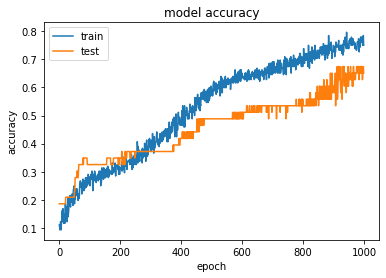

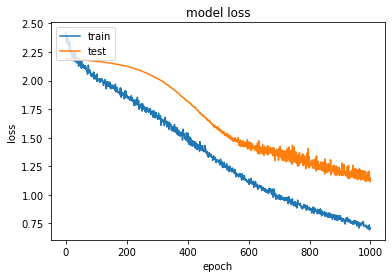

In [20]:
model = build_model_light_LSTM()
history = model.fit(X_train, y_train, epochs=1000, batch_size=172, validation_data=[X_test, y_test])
model.evaluate(X_test, y_test)
show_history(history)